In [1]:
import numpy
from etrade.spot.trader import Station
from etrade.spot.market.recycle import BasicRecycle, PointwiseRecycle
from etrade.spot.forecast.market import DistributiveSeries, DistributiveMarket
from etrade.spot.forecast.plan_a.constructor import *
from etrade.spot.forecast.yieldindex import zero_quantile
from etrade.spot.forecast import yieldindex
from  data_utils.stochastic_utils.vdistributions.abstract import AbstractDistribution
from  data_utils.stochastic_utils.vdistributions.parameter.continuous.basic import NormalDistribution, SkewNormalDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.kernel2 import KernelMixDistribution
from data_utils.stochastic_utils.vdistributions.tools.divergence import kl_divergence_continuous, crps, quantile_RMSE

from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.mfk.skewnd2 import dof_snd_fitter

from scipy.optimize import differential_evolution

from matplotlib import pyplot
import json

In [2]:

with open(r"..\forecast\plan_a\data\market_simulator_3.json", "r") as f:
    train_data = json.loads(f.read())
    
with open(r"..\forecast\plan_a\data\market_simulator_4.json", "r") as f:
    test_data = json.loads(f.read())

In [3]:
train_data =numpy.asarray(train_data["data"])
test_data =numpy.asarray(test_data["data"])

In [4]:
market_len = 1
l = 3 * market_len + market_len
def zscore_p(x):
    x = numpy.asarray(x)
    m = numpy.mean(x, axis=0)
    s = numpy.std(x, ddof=1, axis=0)
    return m,s

def zscore(x, m, s):
    x = numpy.asarray(x)
    m = numpy.asarray(m)
    s = numpy.asarray(s)
    return numpy.column_stack((
            (x[:,:l]-m[:l]) / s[:l], x[:,l]
    ))

def minmax_p(x):
    x = numpy.asarray(x)
    mmax = numpy.max(x, axis=0)
    mmin = numpy.min(x, axis=0)
    return mmin, mmax

def minmax(x, mmin, mmax):
    x = numpy.asarray(x)
    mmin = numpy.asarray(mmin)
    mmax = numpy.asarray(mmax)
    # return (x-mmin) / (mmax-mmin)
    return numpy.column_stack((
            (x[:,:l]-mmin[:l]) / (mmax[:l]-mmin[:l]), x[:,l]
    ))
    
    
    

In [5]:
m,s= zscore_p(train_data)
zscored_t = zscore(train_data, m, s)
zscored_x = zscore(test_data, m, s)

mmin,mmax = minmax_p(train_data)
minmaxed_t = minmax(train_data, mmin, mmax)
minmaxed_x = minmax(test_data, mmin, mmax)

In [93]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
p = MLPRegressor(
    hidden_layer_sizes=[50] * 4,
    activation="relu",
    solver="adam",
    # alpha=1e-3,
    # learning_rate_init=1e-3
)
# p = RandomForestRegressor(
#     # alpha=0.999
# )
# p = SVR(
#     kernel="linear",
#     # alpha=1e-3
# )
p.fit(
    minmaxed_t[:,:l],
    minmaxed_t[:,l]
)

MLPRegressor(hidden_layer_sizes=[50, 50, 50, 50])

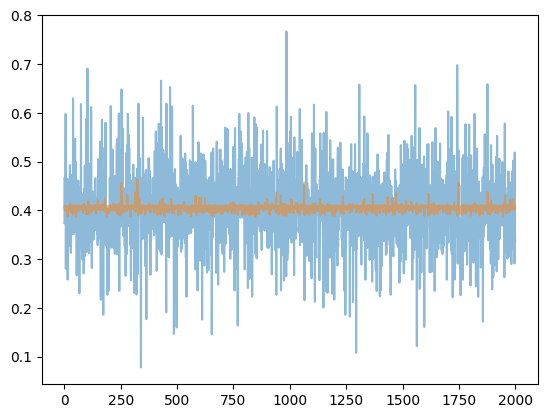

In [94]:

pyplot.plot(minmaxed_t[:,l], alpha=0.5)
pyplot.plot(p.predict(minmaxed_t[:,:l]), alpha=0.5)

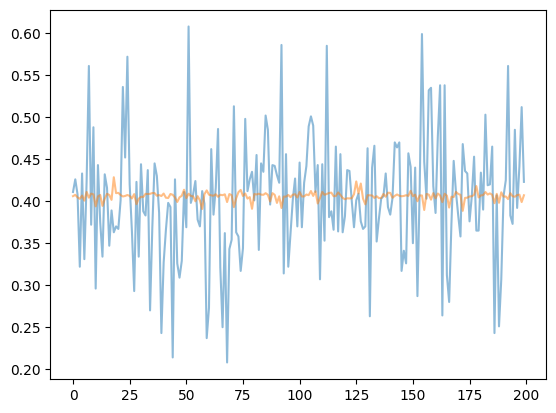

In [95]:

pyplot.plot(minmaxed_x[:,l], alpha=0.5)
pyplot.plot(p.predict(minmaxed_x[:,:l]), alpha=0.5)

In [96]:
p.score(zscored_x[:,:l], zscored_x[:,l])

-2.1774400002866554

In [97]:
p.score(zscored_t[:,:l], zscored_t[:,l])

-1.8835511500815865

In [98]:
train_data

array([[ 4.37723639, 10.47926847,  2.86081866,  0.04244278,  0.374     ],
       [ 4.05464264,  5.08765279,  1.70480785,  0.04145374,  0.379     ],
       [ 3.38995627,  1.81054131,  1.50119439,  0.02164904,  0.468     ],
       ...,
       [ 5.8652883 , 10.52293406,  2.97973106,  0.01103552,  0.519     ],
       [ 5.04519994,  5.52885602,  1.42521578,  0.07153472,  0.363     ],
       [ 4.04756547,  1.16385054,  9.34698121,  0.02143052,  0.337     ]])

In [92]:
print(minmaxed_t[:10].tolist())

[[0.1796100388082371, 0.3781701218062403, 0.0937059640890372, 0.07608164013274481, 0.374], [0.16637313038233342, 0.17801124042314567, 0.051464943827503405, 0.07427165811412453, 0.379], [0.13909922224952403, 0.056351425474663604, 0.044024839843121805, 0.03802834634053526, 0.468], [0.24778004030892972, 0.07047466266624054, 0.3129262468552239, 0.15174240444839576, 0.384], [0.2930055580124015, 0.04511565775347799, 0.07267071722175943, 0.0023833020501384515, 0.384], [0.2997458217770442, 0.1287648045189005, 0.06428603083422788, 0.018659991448033746, 0.417], [0.34492713285952764, 0.06400686808652649, 0.3183888541526663, 0.10352917279213263, 0.598], [0.6167167408254182, 0.052995463975559855, 0.039063746396523415, 0.10111285862761485, 0.28], [0.2302679851201265, 0.08507724439899471, 0.04826748761947796, 0.039663507265199446, 0.467], [0.09154157155171516, 0.15101469271333046, 0.31615398413206103, 0.0535602280257793, 0.313]]
